## Import libraries

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler

# 1. Model

## Load data

In [ ]:
#path to the data
path = '/content/drive/MyDrive/Daten komplett.csv'
data = pd.read_csv(path)

## Plotting data

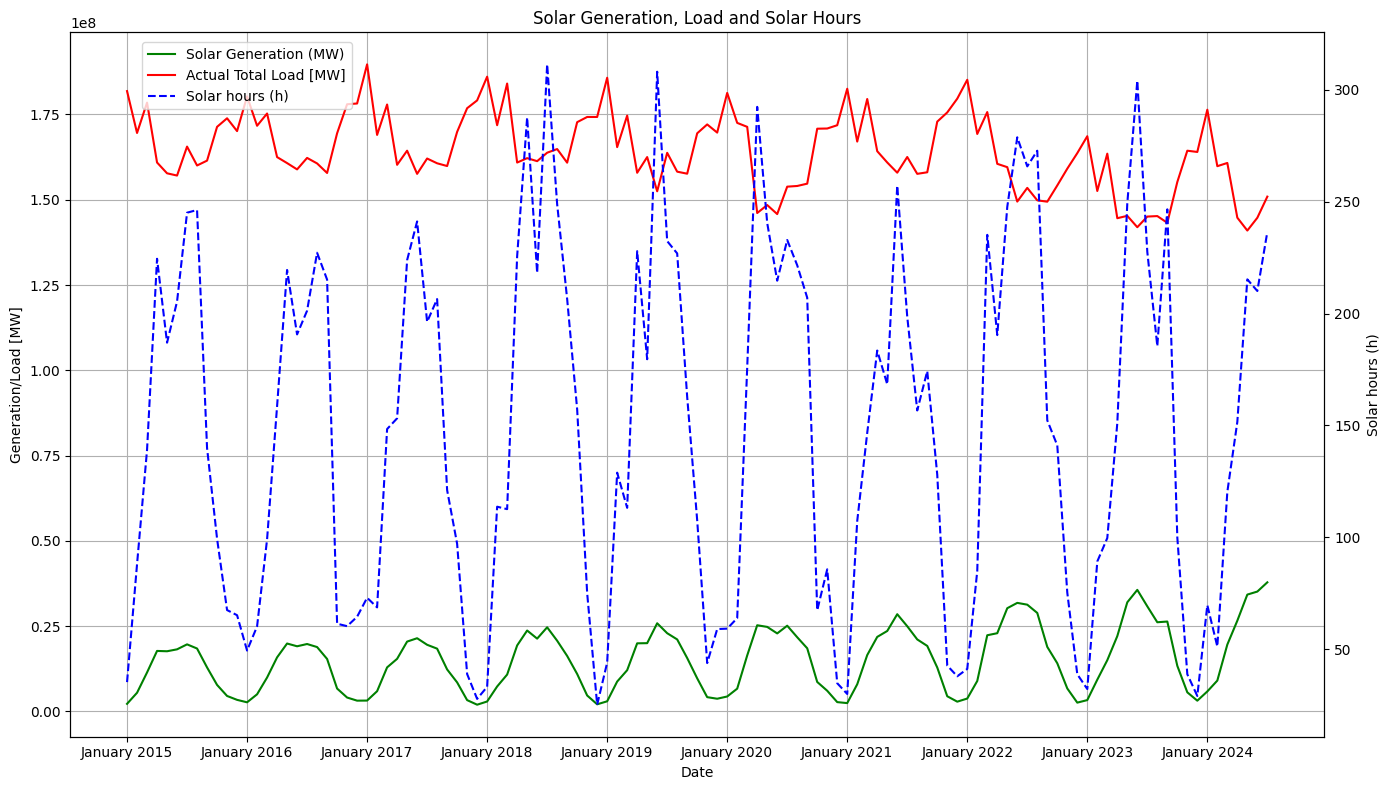

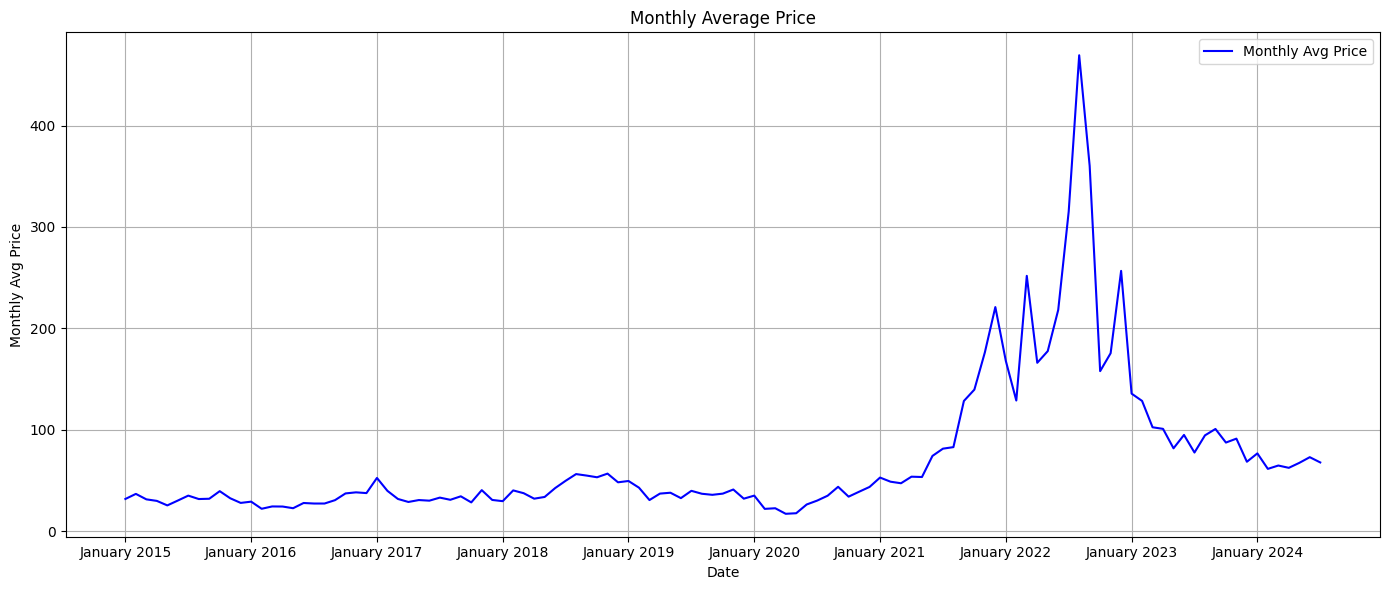

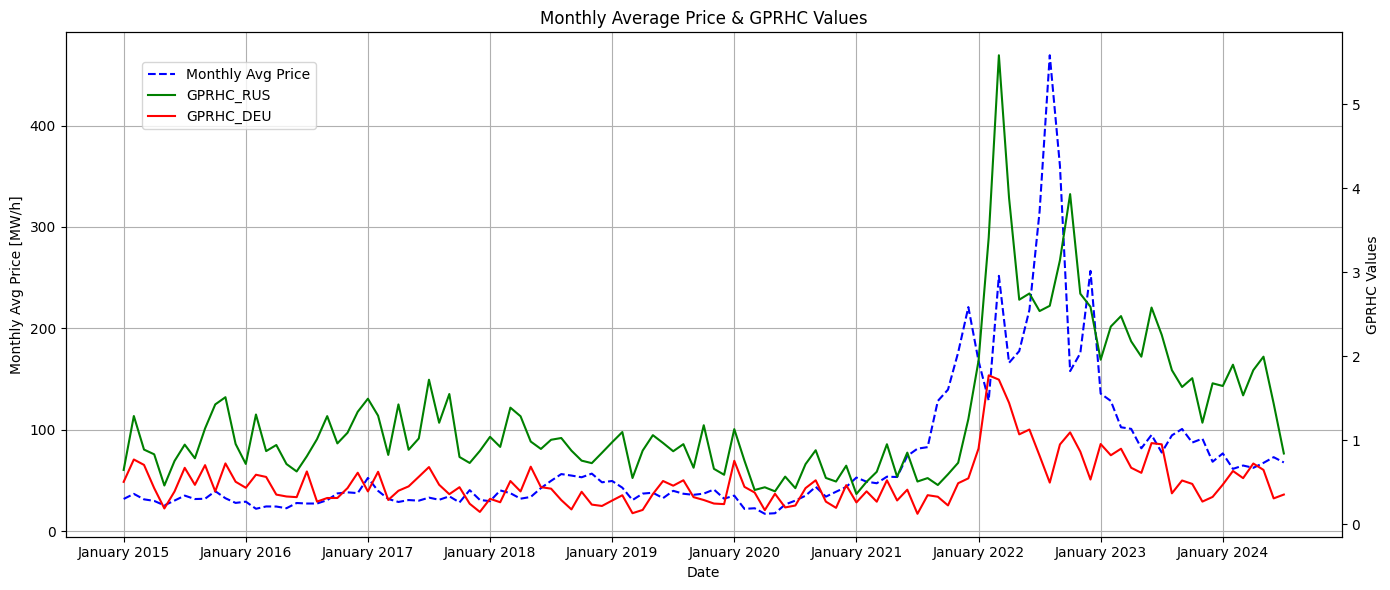

In [ ]:
#Plot solar generation, load and solar hours
fig, ax1 = plt.subplots(figsize=(14, 8))
ax1.plot(data['Date'], data['Solar Generation (MW)'], label='Solar Generation (MW)', color='green')
ax1.plot(data['Date'], data['Actual Total Load [MW]'], label='Actual Total Load [MW]', color='red')
ax1.set_xlabel('Date')
ax1.set_ylabel('Generation/Load [MW]')
ax1.grid(True)
ax1.set_xticks(data['Date'][::12])
ax2 = ax1.twinx()
ax2.plot(data['Date'], data['Solar hours (h)'], label='Solar hours (h)', color='blue', linestyle='--')
ax2.set_ylabel('Solar hours (h)', color='black')
ax2.tick_params(axis='y', labelcolor='black')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.95))
plt.title('Solar Generation, Load and Solar Hours')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Solar generation, load and solar hours.png', dpi=300, bbox_inches='tight' )
plt.show()

#Plot monthly average price
plt.figure(figsize=(14, 6))
plt.plot(data['Date'], data['Monthly_Avg_Price'], label='Monthly Avg Price', color='blue')
plt.xlabel('Date')
plt.ylabel('Monthly Avg Price')
plt.title('Monthly Average Price')
plt.grid(True)
plt.xticks(data['Date'][::12])
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('Monthly average price.png', dpi=300, bbox_inches='tight' )
plt.show()

#Plot monthly average price and gpr index
fig, ax1 = plt.subplots(figsize=(14, 6))
ax1.plot(data['Date'], data['Monthly_Avg_Price'], label='Monthly Avg Price', color='blue', linestyle='--')
ax1.set_xlabel('Date')
ax1.set_ylabel('Monthly Avg Price [MW/h]')
ax1.tick_params(axis='y')
ax1.grid(True)
ax1.set_xticks(data['Date'][::12])
ax2 = ax1.twinx()
ax2.plot(data['Date'], data['GPRHC_RUS'], label='GPRHC_RUS', color='green')
ax2.plot(data['Date'], data['GPRHC_DEU'], label='GPRHC_DEU', color='red')
ax2.set_ylabel('GPRHC Values')
ax2.tick_params(axis='y')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.title('Monthly Average Price & GPRHC Values')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('gpr values and price.png', dpi=300, bbox_inches='tight' )
plt.show()

## Split into training and test data

In [ ]:
#convert date to date-time format
data['Date'] = pd.to_datetime(data['Date'], format='%B %Y')

#split date
data['year'] = data['Date'].dt.year
data['month'] = data['Date'].dt.month
data['day'] = data['Date'].dt.day

#remove date column
data = data.drop(columns=['Date'])

# Features und Zielvariable definieren
X = data[['year','month', 'day', 'Solar hours (h)', 'Solar Generation (MW)',
          'Day-ahead Total Load Forecast [MW]', 'Actual Total Load [MW]',
          'Solar Prognose (Day-Ahead D-1 18:00)', 'Solar_Prognose_diff']]
y = data['Monthly_Avg_Price']


#scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#split training data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y,test_size=0.2, random_state=42)

Initiate regression model

In [ ]:
rf_model = RandomForestRegressor()

cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5)
cv_scores_mean = cv_scores.mean()

#train model
rf_model.fit(X_train, y_train)

y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

#prediction based on the test data
y_pred = rf_model.predict(X_test)

Generation of model outputs

In [ ]:
#calucalteing errors
mae = mean_absolute_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

rmse = mse ** 0.5

#print results
print("CV R^2:", cv_scores.mean())
print(f'R^2 Test: {r2:.2f}')
print(f'MAE Test: {mae:.2f}')
print(f'RMSE Test: {rmse:.2f}')
print(f'MAE Train: {mae_train:.2f}')
print(f'R^2 Train: {r2_train:.2f}')

CV R^2: 0.4408011483444909
R^2 Test: 0.78
MAE Test: 13.62
RMSE Test: 20.61
MAE Train: 8.65
R^2 Train: 0.96


Generating plots

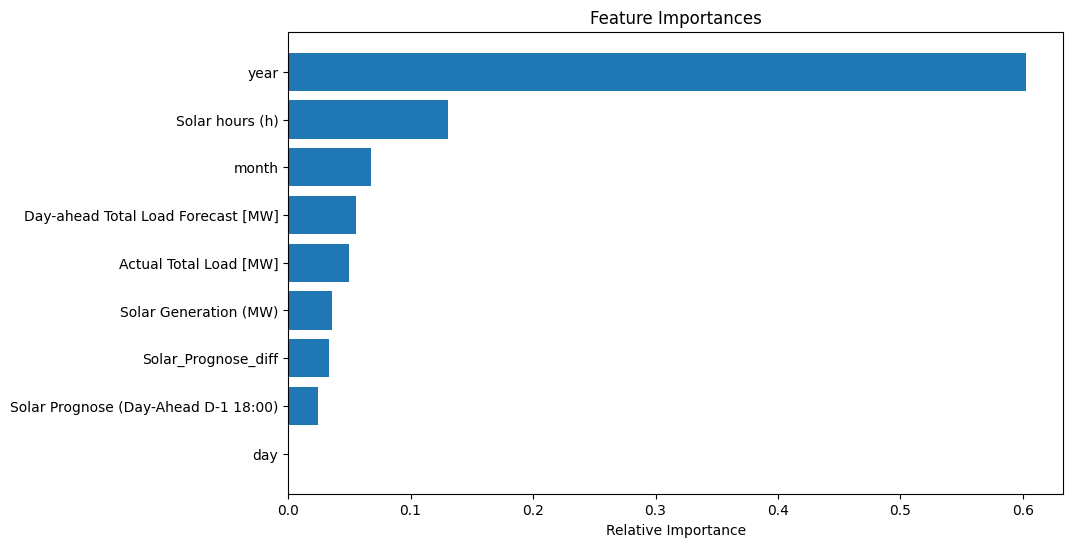

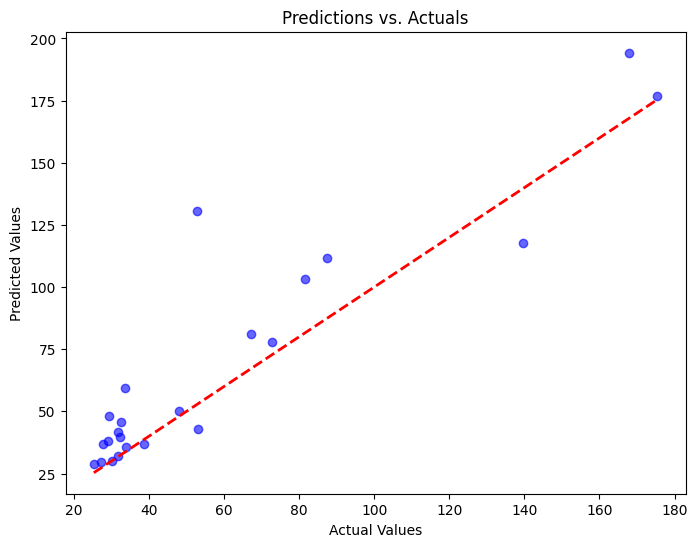

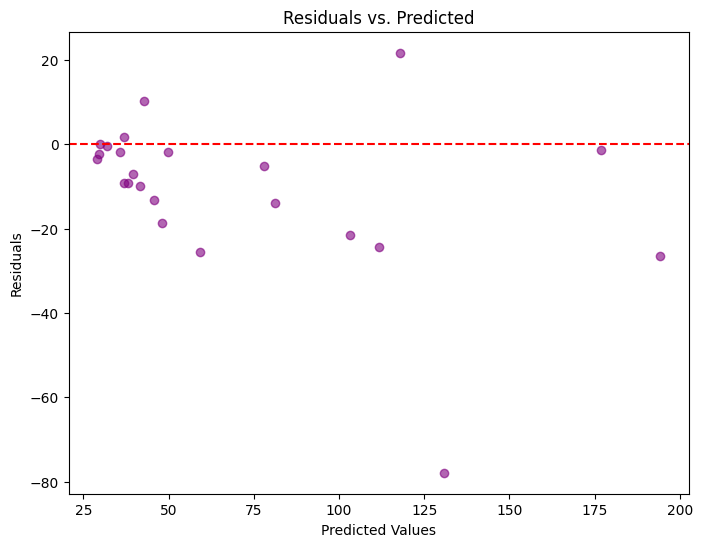

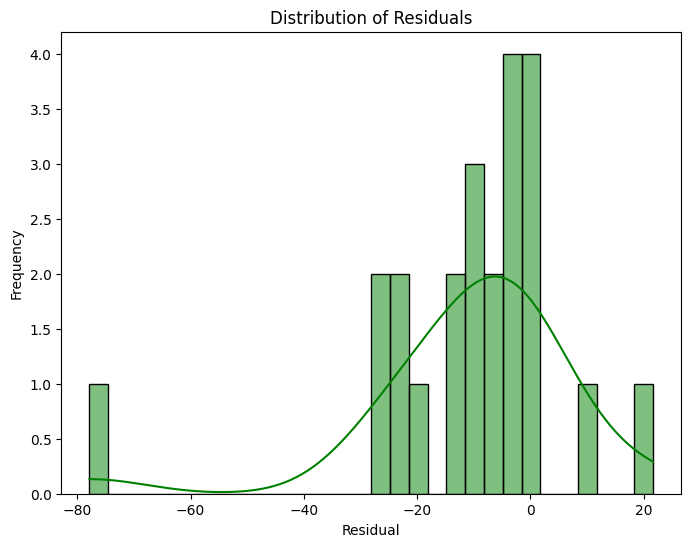

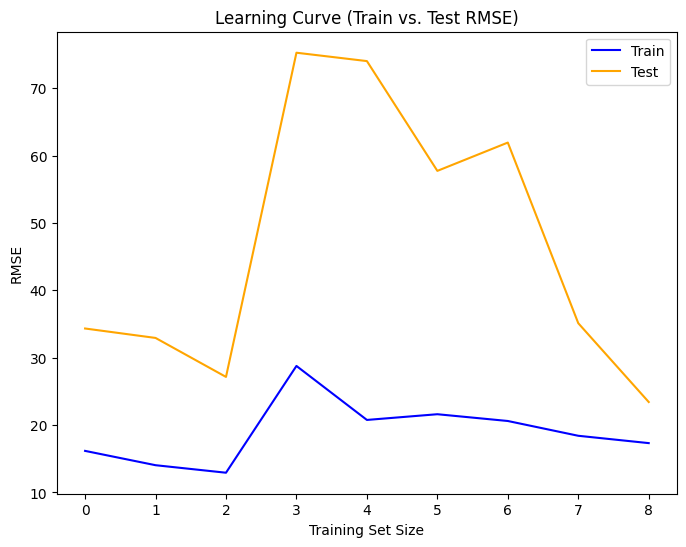

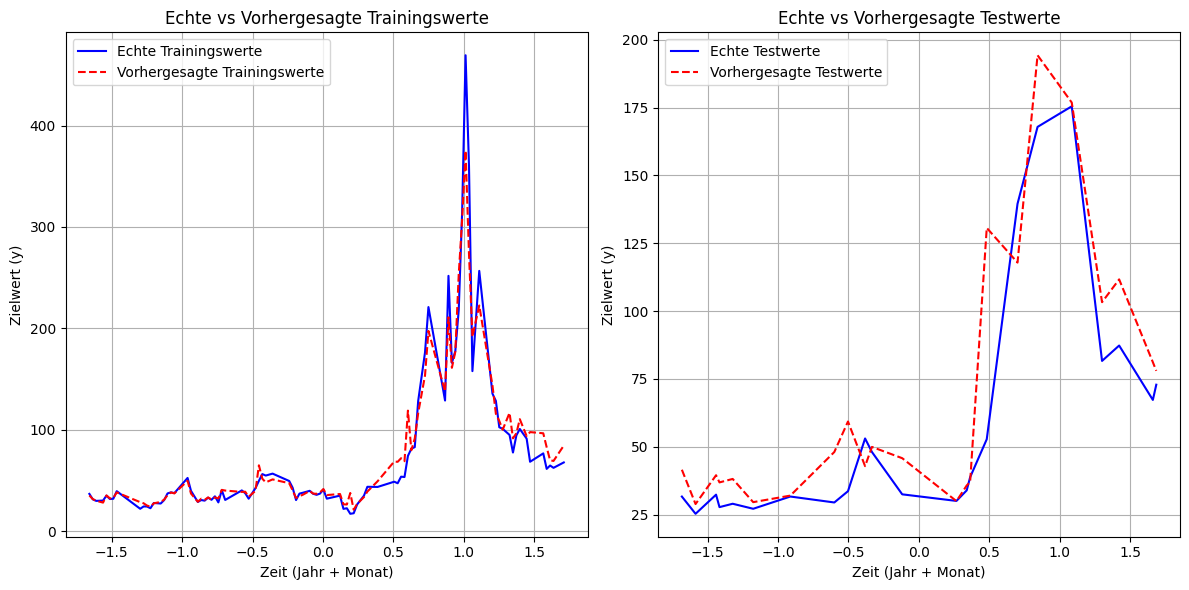

In [ ]:
# 1. Feature Importance Plot
feature_importances = rf_model.feature_importances_
features = X.columns
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.barh(range(len(indices)), feature_importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("Relative Importance")
plt.gca().invert_yaxis()
plt.show()

# 2. Predictions vs Actuals Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, color='blue', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r', linewidth=2)
plt.title("Predictions vs. Actuals")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()

# 3. Residual Plot
residuals = y_test - y_test_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_test_pred, residuals, color='purple', alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs. Predicted")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

# 4. Distribution of Errors
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, color='green', bins=30)
plt.title("Distribution of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

# 5. Learning Curve (Train vs Test Performance)
train_errors = []
test_errors = []

for m in range(10, len(X_train), 10):
    rf_model.fit(X_train[:m], y_train[:m])
    y_train_pred_m = rf_model.predict(X_train[:m])
    y_test_pred_m = rf_model.predict(X_test)
    train_errors.append(mean_squared_error(y_train[:m], y_train_pred_m))
    test_errors.append(mean_squared_error(y_test, y_test_pred_m))

plt.figure(figsize=(8, 6))
plt.plot(np.sqrt(train_errors), label="Train", color='blue')
plt.plot(np.sqrt(test_errors), label="Test", color='orange')
plt.title("Learning Curve (Train vs. Test RMSE)")
plt.xlabel("Training Set Size")
plt.ylabel("RMSE")
plt.legend()
plt.show()


# Daten für den Plot aufbereiten
train_sorted = pd.DataFrame({
    'year': X_train[:, 0],  # Jahr
    'month': X_train[:, 1],  # Monat
    'y_value': y_train,
    'preds': y_train_pred
})
train_sorted = train_sorted.sort_values(by=['year', 'month'])

test_sorted = pd.DataFrame({
    'year': X_test[:, 0],  # Jahr
    'month': X_test[:, 1],  # Monat
    'y_value': y_test,
    'preds': y_test_pred
})
test_sorted = test_sorted.sort_values(by=['year', 'month'])

# Plot erstellen
plt.figure(figsize=(12, 6))

# Trainingsdaten plotten
plt.subplot(1, 2, 1)
plt.plot(train_sorted['year'] + train_sorted['month']/12, train_sorted['y_value'], label='Echte Trainingswerte', color='blue')
plt.plot(train_sorted['year'] + train_sorted['month']/12, train_sorted['preds'], label='Vorhergesagte Trainingswerte', linestyle='--', color='red')
plt.xlabel('Zeit (Jahr + Monat)')
plt.ylabel('Zielwert (y)')
plt.title('Echte vs Vorhergesagte Trainingswerte')
plt.legend()
plt.grid(True)

# Testdaten plotten
plt.subplot(1, 2, 2)
plt.plot(test_sorted['year'] + test_sorted['month']/12, test_sorted['y_value'], label='Echte Testwerte', color='blue')
plt.plot(test_sorted['year'] + test_sorted['month']/12, test_sorted['preds'], label='Vorhergesagte Testwerte', linestyle='--', color='red')
plt.xlabel('Zeit (Jahr + Monat)')
plt.ylabel('Zielwert (y)')
plt.title('Echte vs Vorhergesagte Testwerte')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 2. Model (Hyperparameter tuning and cv)

## Load data

In [ ]:
#path to data
path = '/content/drive/MyDrive/Daten komplett.csv'
data = pd.read_csv(path)

## Define variables and split into training and test data

In [ ]:
#convert date to date-time format
data['Date'] = pd.to_datetime(data['Date'], format='%B %Y')

#split date
data['year'] = data['Date'].dt.year
data['month'] = data['Date'].dt.month
data['day'] = data['Date'].dt.day

#remove date column
data = data.drop(columns=['Date'])

#define featurs and variables
X = data[['year','month','day', 'Solar hours (h)', 'Solar Generation (MW)',
          'Day-ahead Total Load Forecast [MW]', 'Actual Total Load [MW]',
          'Solar Prognose (Day-Ahead D-1 18:00)', 'Solar_Prognose_diff']]
y = data['Monthly_Avg_Price']

#scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#split training data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y,test_size=0.2, random_state=42)

## Initiate regression model

In [ ]:
#convert date to date-time format
rf_model = RandomForestRegressor(random_state=42)

#defince parameters for grid search
param_grid = {
    'n_estimators': [1,2,3,4,10,20,30,40, 50, 100],
    'max_depth': [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, None],
    'min_samples_split': [2,3,4,5,10,20,30,40,50, 60],
    'max_features': ['sqrt']
}

#initialise gridsearch
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)

#train model
grid_search.fit(X_train, y_train)

#apply model with the best paramters from gridsearch
rf_model = grid_search.best_estimator_

y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

Fitting 5 folds for each of 1400 candidates, totalling 7000 fits


## Generation of model outputs

In [ ]:
#calucalteing errors
mae = mean_absolute_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)
rmse = mse ** 0.5

cv_r2_scores = grid_search.cv_results_['mean_test_score']
best_cv_r2 = cv_r2_scores[grid_search.best_index_]

#print results
print(f'CV-R²: {best_cv_r2:.2f}')
print(f'R^2 Test: {r2:.2f}')
print(f'MAE Test: {mae:.2f}')
print(f'RMSE Test: {rmse:.2f}')
print(f'MAE Train: {mae_train:.2f}')
print(f'R^2 Train: {r2_train:.2f}')

CV-R²: 0.53
R^2 Test: 0.53
MAE Test: 20.97
RMSE Test: 29.89
MAE Train: 10.54
R^2 Train: 0.94


## Plot the data

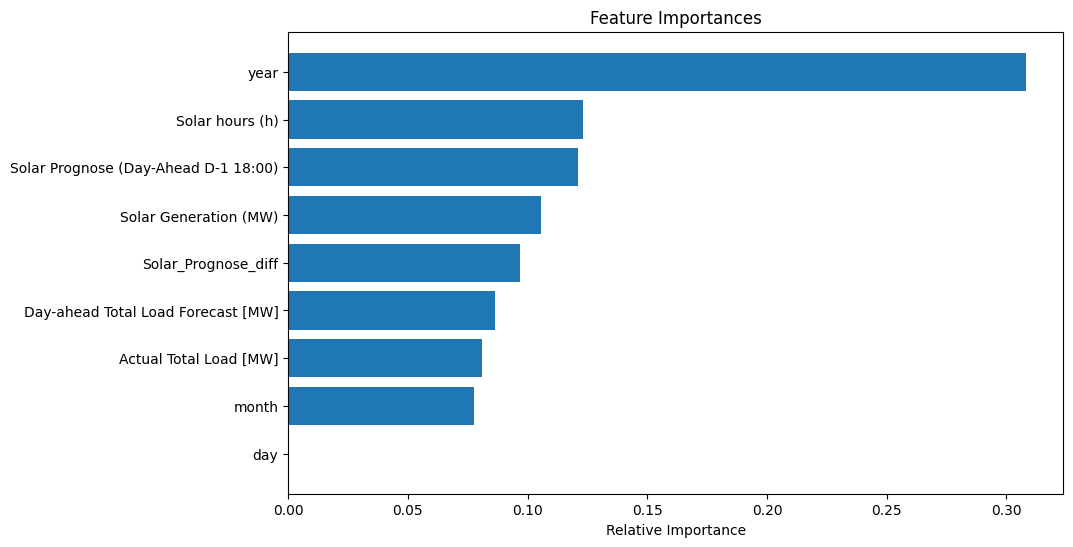

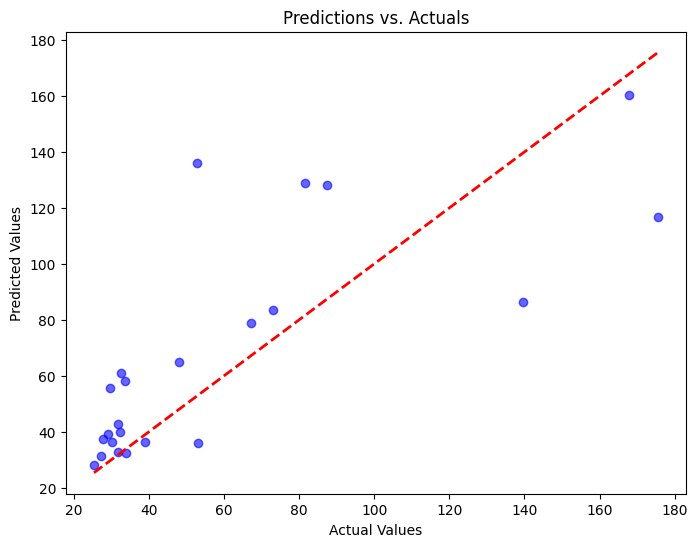

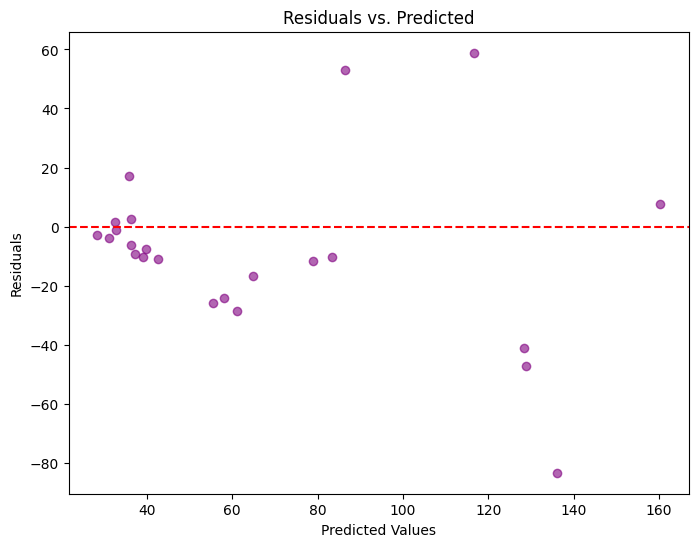

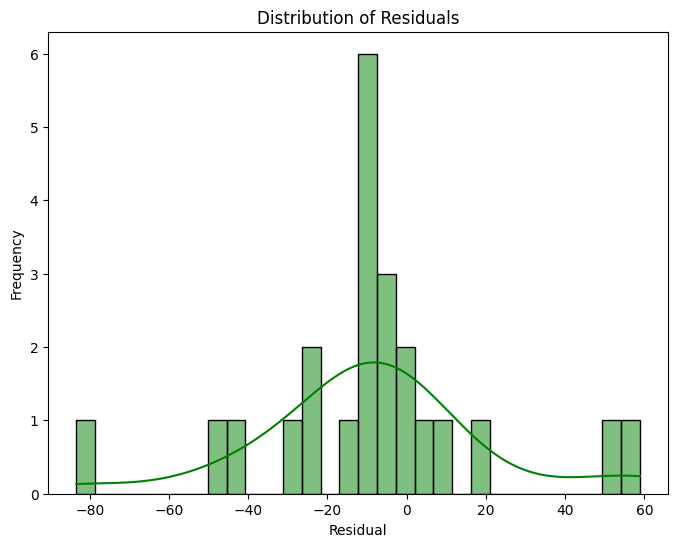

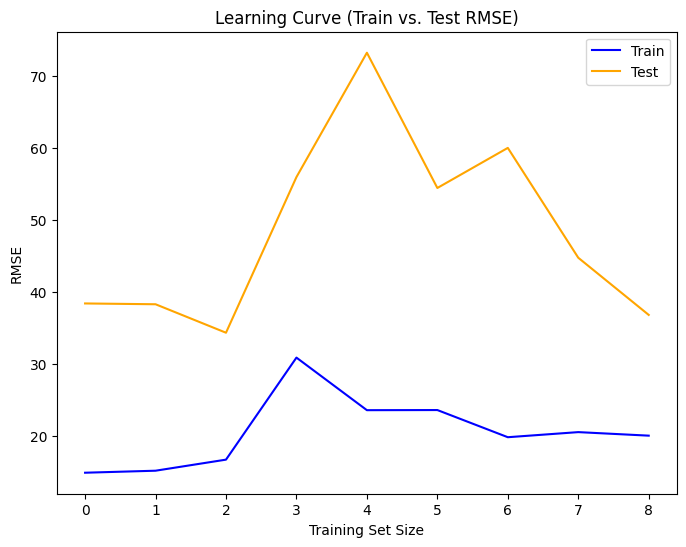

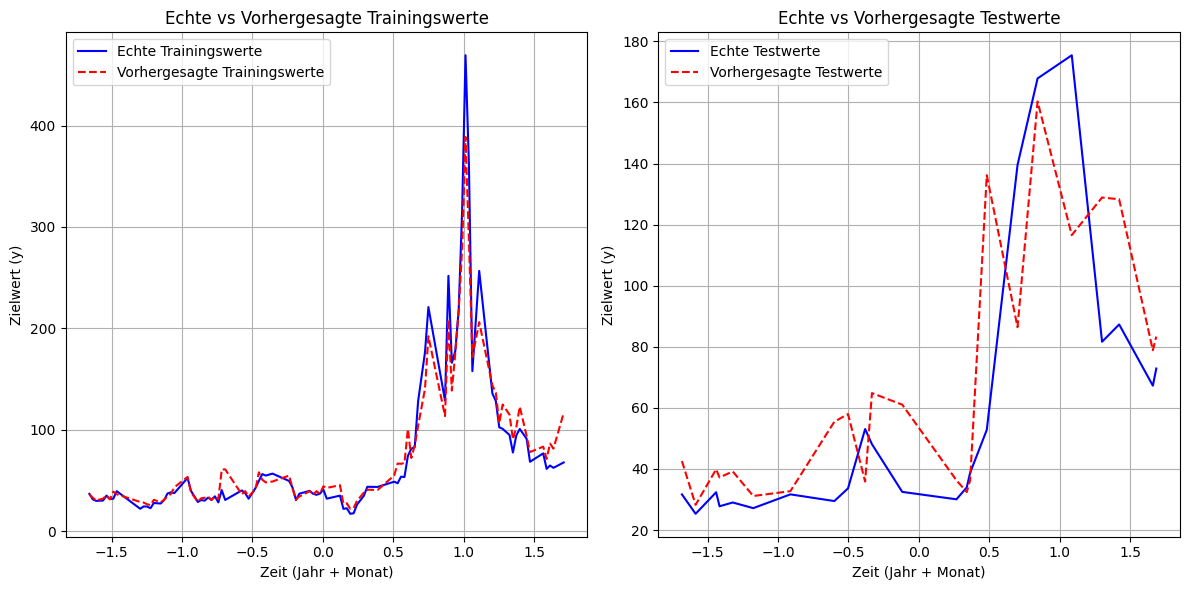

In [ ]:
#1. Feature Importance Plot
feature_importances = rf_model.feature_importances_
features = X.columns
indices = np.argsort(feature_importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.barh(range(len(indices)), feature_importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("Relative Importance")
plt.gca().invert_yaxis()
plt.savefig('feature_importance_plot.png', dpi=300, bbox_inches='tight' )
plt.show()


#2. Predictions vs Actuals Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, color='blue', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r', linewidth=2)
plt.title("Predictions vs. Actuals")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()

#3. Residual Plot
residuals = y_test - y_test_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_test_pred, residuals, color='purple', alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs. Predicted")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

#4. Distribution of Errors (Residuals Histogram)
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, color='green', bins=30)
plt.title("Distribution of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

#5. Learning Curve (Train vs Test Performance)
train_errors = []
test_errors = []

for m in range(10, len(X_train), 10):
    rf_model.fit(X_train[:m], y_train[:m])
    y_train_pred_m = rf_model.predict(X_train[:m])
    y_test_pred_m = rf_model.predict(X_test)
    train_errors.append(mean_squared_error(y_train[:m], y_train_pred_m))
    test_errors.append(mean_squared_error(y_test, y_test_pred_m))

plt.figure(figsize=(8, 6))
plt.plot(np.sqrt(train_errors), label="Train", color='blue')
plt.plot(np.sqrt(test_errors), label="Test", color='orange')
plt.title("Learning Curve (Train vs. Test RMSE)")
plt.xlabel("Training Set Size")
plt.ylabel("RMSE")
plt.legend()
plt.show()

#plot test and training values
train_sorted = pd.DataFrame({
    'year': X_train[:, 0],
    'month': X_train[:, 1],
    'y_value': y_train,
    'preds': y_train_pred
})
train_sorted = train_sorted.sort_values(by=['year', 'month'])
test_sorted = pd.DataFrame({
    'year': X_test[:, 0],
    'month': X_test[:, 1],
    'y_value': y_test,
    'preds': y_test_pred
})
test_sorted = test_sorted.sort_values(by=['year', 'month'])
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_sorted['year'] + train_sorted['month']/12, train_sorted['y_value'], label='Echte Trainingswerte', color='blue')
plt.plot(train_sorted['year'] + train_sorted['month']/12, train_sorted['preds'], label='Vorhergesagte Trainingswerte', linestyle='--', color='red')
plt.xlabel('Zeit (Jahr + Monat)')
plt.ylabel('Zielwert (y)')
plt.title('Echte vs Vorhergesagte Trainingswerte')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(test_sorted['year'] + test_sorted['month']/12, test_sorted['y_value'], label='Echte Testwerte', color='blue')
plt.plot(test_sorted['year'] + test_sorted['month']/12, test_sorted['preds'], label='Vorhergesagte Testwerte', linestyle='--', color='red')
plt.xlabel('Zeit (Jahr + Monat)')
plt.ylabel('Zielwert (y)')
plt.title('Echte vs Vorhergesagte Testwerte')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Model (Hyperparameter tunging, cv and gpr)

## Load data

In [ ]:
path = '/content/drive/MyDrive/Daten komplett.csv'
data = pd.read_csv(path)

## Define variables and split into training and test data

In [ ]:
#convert date to date-time format
data['Date'] = pd.to_datetime(data['Date'], format='%B %Y')

#split date
data['year'] = data['Date'].dt.year
data['month'] = data['Date'].dt.month
data['day'] = data['Date'].dt.day

#remove date column
data = data.drop(columns=['Date'])

#define featurs and variables
X = data[['year','month','day', 'GPRHC_DEU','GPRHC_RUS', 'Solar hours (h)', 'Solar Generation (MW)',
          'Day-ahead Total Load Forecast [MW]', 'Actual Total Load [MW]',
          'Solar Prognose (Day-Ahead D-1 18:00)', 'Solar_Prognose_diff']]
y = data['Monthly_Avg_Price']

#scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#split training data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y,test_size=0.2, random_state=42)

## Initiate regression model

In [ ]:
#convert date to date-time format
rf_model = RandomForestRegressor(random_state=42)

#defince parameters for grid search
param_grid = {
    'n_estimators': [1,2,3,4,10,20,30,40, 50, 100],
    'max_depth': [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, None],
    'min_samples_split': [2,3,4,5,10,20,30,40,50, 60],
    'max_features': ['sqrt']
}

#initialise gridsearch
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)

#train model
grid_search.fit(X_train, y_train)

#apply model with the best paramters from gridsearch
rf_model = grid_search.best_estimator_

y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

Fitting 5 folds for each of 1400 candidates, totalling 7000 fits


## Generation of model outputs

In [ ]:
#calucalteing errors
mae = mean_absolute_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)
rmse = mse ** 0.5

cv_r2_scores = grid_search.cv_results_['mean_test_score']
best_cv_r2 = cv_r2_scores[grid_search.best_index_]

#print results
print(f'CV-R²: {best_cv_r2:.2f}')
print(f'R^2 Test: {r2:.2f}')
print(f'MAE Test: {mae:.2f}')
print(f'RMSE Test: {rmse:.2f}')
print(f'MAE Train: {mae_train:.2f}')
print(f'R^2 Train: {r2_train:.2f}')

#safe gridsearch results to csv to evaluate the parameters
searchresults = pd.DataFrame(grid_search.cv_results_)
searchresults = searchresults.sort_values(by='rank_test_score')
searchresults.to_csv('searchresults.csv')

CV-R²: 0.56
R^2 Test: 0.62
MAE Test: 20.01
RMSE Test: 26.89
MAE Train: 11.03
R^2 Train: 0.93


## Model result plots

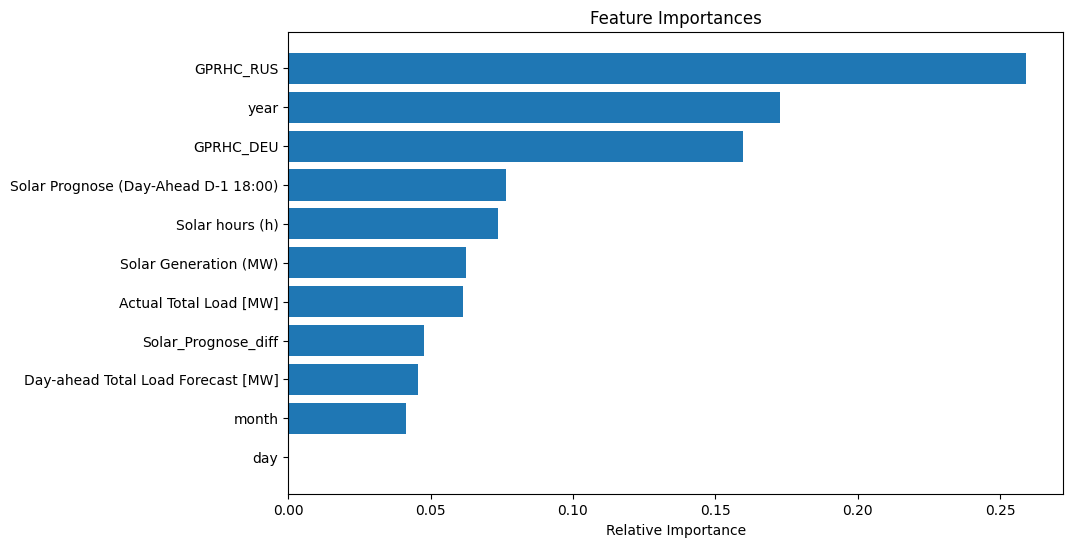

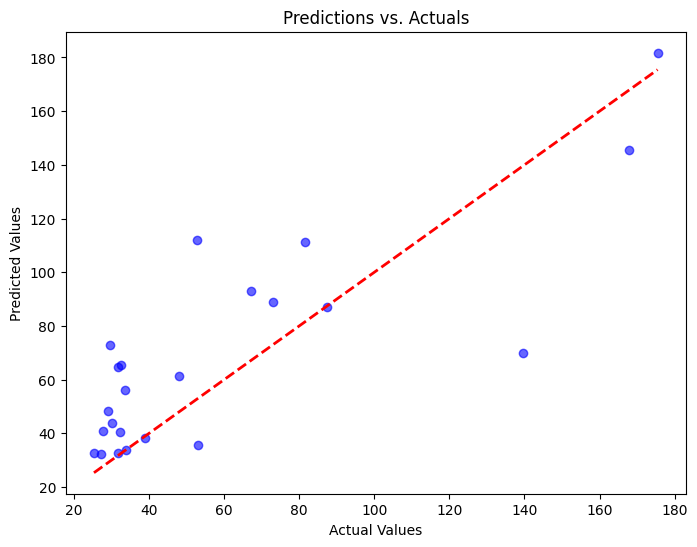

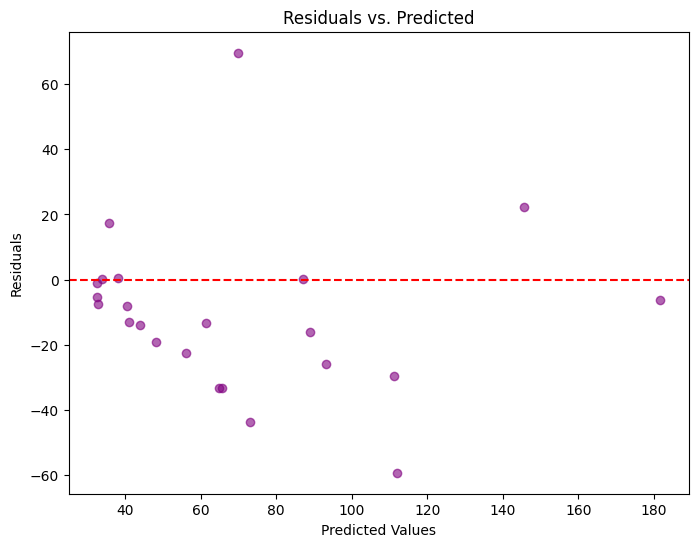

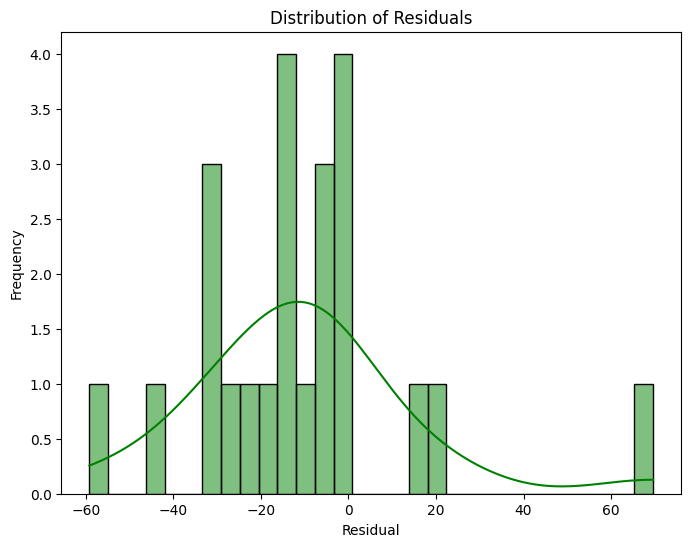

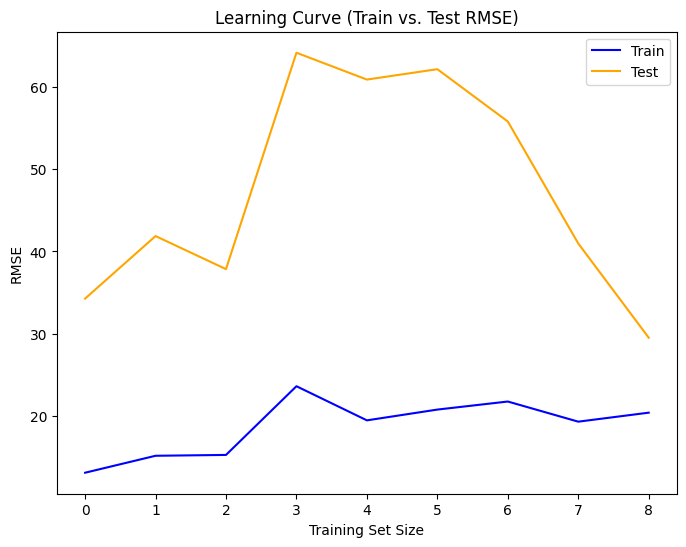

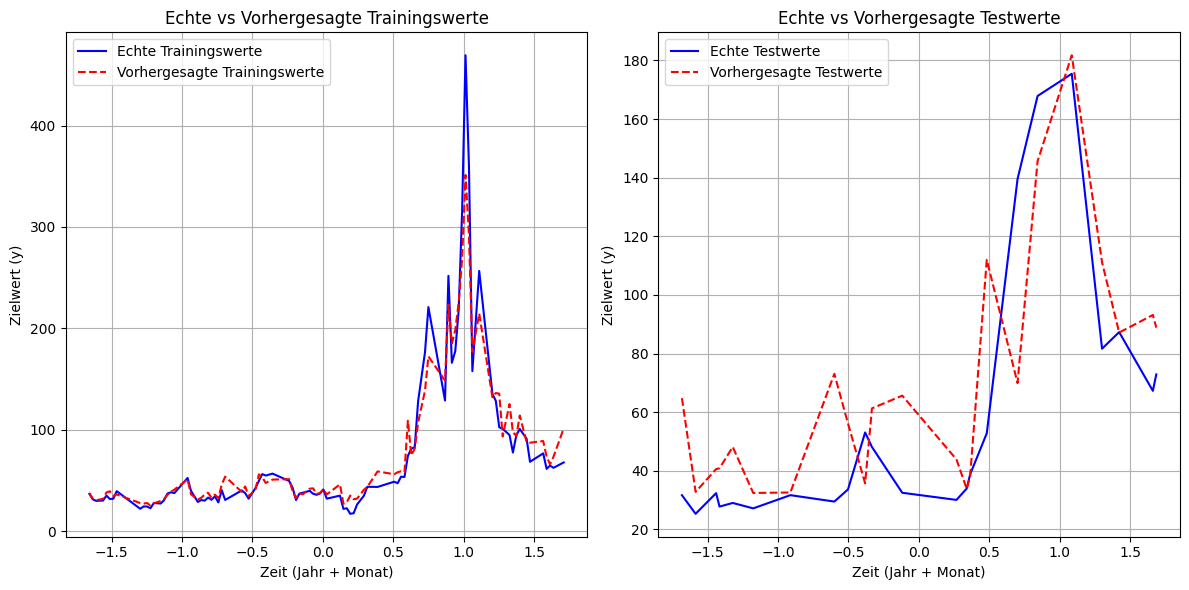

In [ ]:
#1. Feature Importance Plot
feature_importances = rf_model.feature_importances_
features = X.columns
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.barh(range(len(indices)), feature_importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("Relative Importance")
plt.gca().invert_yaxis()
plt.savefig('feature_importance_plot.png', dpi=300, bbox_inches='tight' )
plt.show()


#2. Predictions vs Actuals Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, color='blue', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r', linewidth=2)
plt.title("Predictions vs. Actuals")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()

#3. Residual Plot
residuals = y_test - y_test_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_test_pred, residuals, color='purple', alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs. Predicted")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

#4. Distribution of Errors (Residuals Histogram)
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, color='green', bins=30)
plt.title("Distribution of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

#5. Learning Curve (Train vs Test Performance)
train_errors = []
test_errors = []

for m in range(10, len(X_train), 10):
    rf_model.fit(X_train[:m], y_train[:m])
    y_train_pred_m = rf_model.predict(X_train[:m])
    y_test_pred_m = rf_model.predict(X_test)
    train_errors.append(mean_squared_error(y_train[:m], y_train_pred_m))
    test_errors.append(mean_squared_error(y_test, y_test_pred_m))

plt.figure(figsize=(8, 6))
plt.plot(np.sqrt(train_errors), label="Train", color='blue')
plt.plot(np.sqrt(test_errors), label="Test", color='orange')
plt.title("Learning Curve (Train vs. Test RMSE)")
plt.xlabel("Training Set Size")
plt.ylabel("RMSE")
plt.legend()
plt.show()


#plot test and training values
train_sorted = pd.DataFrame({
    'year': X_train[:, 0],
    'month': X_train[:, 1],
    'y_value': y_train,
    'preds': y_train_pred
})
train_sorted = train_sorted.sort_values(by=['year', 'month'])
test_sorted = pd.DataFrame({
    'year': X_test[:, 0],
    'month': X_test[:, 1],
    'y_value': y_test,
    'preds': y_test_pred
})
test_sorted = test_sorted.sort_values(by=['year', 'month'])
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_sorted['year'] + train_sorted['month']/12, train_sorted['y_value'], label='Echte Trainingswerte', color='blue')
plt.plot(train_sorted['year'] + train_sorted['month']/12, train_sorted['preds'], label='Vorhergesagte Trainingswerte', linestyle='--', color='red')
plt.xlabel('Zeit (Jahr + Monat)')
plt.ylabel('Zielwert (y)')
plt.title('Echte vs Vorhergesagte Trainingswerte')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(test_sorted['year'] + test_sorted['month']/12, test_sorted['y_value'], label='Echte Testwerte', color='blue')
plt.plot(test_sorted['year'] + test_sorted['month']/12, test_sorted['preds'], label='Vorhergesagte Testwerte', linestyle='--', color='red')
plt.xlabel('Zeit (Jahr + Monat)')
plt.ylabel('Zielwert (y)')
plt.title('Echte vs Vorhergesagte Testwerte')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Forecast

In [ ]:
new_data = pd.DataFrame({
    'year': [2025],
    'month': [7],
    'day': [1],
    'GPRHC_DEU' : [1],
    'GPRHC_RUS' : [0.5],
    'Solar hours (h)': [311],
    'Solar Generation (MW)': [25849480.0],
    'Day-ahead Total Load Forecast [MW]': [171732015.0],
    'Actual Total Load [MW]': [141944564.0],
    'Solar Prognose (Day-Ahead D-1 18:00)': [25526787.6],
    'Solar_Prognose_diff': [171357260.9]

})

new_data = scaler.transform(new_data)
predicted_price = rf_model.predict(new_data)
print("Vorhergesagter Preis:", predicted_price[0])

Vorhergesagter Preis: 125.8970869047619
